# ***L03:*** Saliency Maps (Image)

In this notebook, you will apply three XAI techniques to derive saliency/attribution maps for a vision model trained to distinguish and classify 1,000 different classes. The maps should then be overlaid on the original image like a heatmap to highlight the regions of the image the model focused on for its classification decision. The model is a high-performing pre-trained Inception network, `inception_v4.pth`, found in the model directory. In the data directory, you will find numpy files for images and labels corresponding to four color images of shape $(299 \times 299)$. By the end of these exercises, you should be able to appreciate the wide variety of techniques available, as well as their particular hyperparameter sensitivities.

<img src="./static/grad_cam.png" alt="LO1 Image" style="width: 60%; height: auto;">  

The above image shows an application of Grad-CAM on a binary classification task of correctly labeling cats and dogs. The gradient information from the model can be used to form a weighted sum of the convolutional layers, which can then be interpolated to the image size to form a heatmap that is overlaid on the original image. Red regions indicate where the model is focusing its attention for the classification task. We see that when we pass the label for dog and cat, the model correctly highlights the corresponding animal.

-------------------------

**Integrated Gradients**  
1. Use your theoretical knowledge of Integrated Gradients to write a simple attribution method that returns a saliency map.
2. Explain the purpose of the prefactor $(x_i-x'_i)$ in the formula for Integrated Gradients.
3. Plot the saliency maps for all images.
4. Change the baseline and comment on the results, do they change?
5. Suggest an explanation for your observation if the results are different and suggest an alternative method.
6. Compare your results by implementing Captum's `IntegratedGradients` method.

**Occlusion**
1. Use Captum's built-in occlusion functionality to derive and plot saliency maps for all images.
2. Analyze how different window sizes affect your results and discuss how you would determine the optimal size.

**Grad-CAM**
1. Use your theoretical knowledge of Grad-CAM to write a simple attribution method that returns a saliency map. 
2. Plot the saliency maps for all images.
3. Use a few different target layers and report on how the saliency map changes with model depth.
4. Compare your results by implementing Captum's `LayerGradCam` method.

-------------------------

In [1]:
# Load necessary libraries

import utils # set of helper functions
import torch # pytorch for deep learning
import cv2 # opencv for image manipulation
import numpy as np # numpy for matrix operations
import matplotlib.pyplot as plt # matplotlib for plotting
from utils import custom_cmap # custom color map for visualizing attributions
from captum.attr import LayerGradCam, Occlusion, IntegratedGradients # captum built in attribution methods
import warnings # to suppress warnings
warnings.filterwarnings("ignore") # ignore warnings

/Users/oliverpejic/Documents/Classes/eai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the pre-trained inception_v4 model and set it to evaluation mode
model = torch.load("../models/inception_v4.pth")
model.eval();

In [3]:
# load images 
images = np.load('../data/images.npy') # images are 299 by 299 and normalize dbetween -1 and 1
# Load corresponding labels
labels = np.load('../data/labels.npy')
print(images.shape, labels.shape)

(4, 299, 299, 3) (4,)


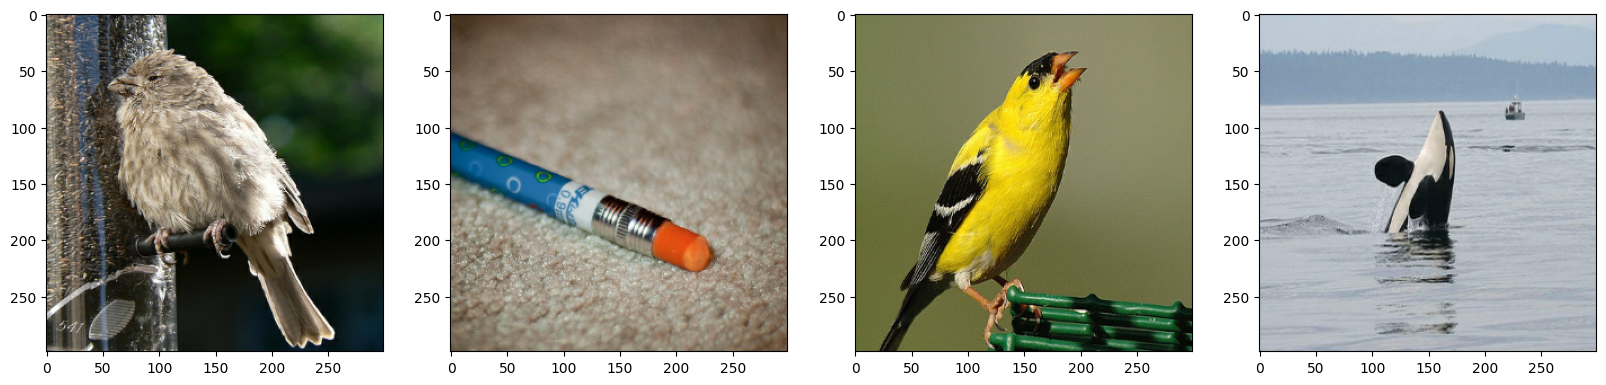

In [4]:
# Plot all normalized images using utils function so the images look good
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i in range(images.shape[0]):
    axs[i].imshow(utils.normalize(images[i]))

<div style="font-size: 10px;">

```python
# You can use the following pattern to plot your attribution results for all images:

fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5)) 

for i, image in enumerate(images):

    # Convert your numpy image to a PyTorch tensor of shape (1, C, H, W)
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()

    # The target class label for the corresponding image
    target_class = int(labels[i])
   
    # Your function or library call here to compute the saliency map
    #-----------------------------------------------------------------

    saliency_map = your_attribution_method(model, target_label)

    #-----------------------------------------------------------------

    # Turn into numpy array and detach if necessary

    # Average over color channels if necessary

    # plot original image if necessary and saliency_map
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(utils.normalize(saliency_map), cmap='some color map', alpha=0.3)
```
</div>

## Integrated Gradients

**1 | Use your theoretical knowledge of Integrated Gradients to write a simple attribution method that returns a saliency map.**

In [8]:
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Scale input by creating a set of images lineraly interpolated between the baseline and the input
    
    scaled_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ]
    
    grads = [] # list to store gradients at each scaled input
    for scaled_input in scaled_inputs:

        # YOUR CODE HERE (remember to set requires_grad=True and to call backward to compute gradients)
        scaled_input.requires_grad_(True)
        model.zero_grad()
        out = model(scaled_input)
        loss = out[0, target_class]
        loss.backward()
        grads.append(scaled_input.grad.detach().cpu().numpy())

    # Approximate the integral of gradients using the trapezoidal rule
    grads = np.array(grads) # convert to numpy array
    avg_grads = (grads[:-1] + grads[1:]) / 2.0 # average gradients at each step of the integral
    integrated_grads = (input_tensor.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * np.mean(avg_grads, axis=0) # compute the integral
    
    return integrated_grads

**2 | Explain the purpose of the prefactor $(x_i-x'_i)$ in the formula for Integrated Gradients**

The factor $(x_i - x'_i)$ does two important things in Integrated Gradients:

1. **Weights by how much the feature changes**  
   It multiplies the average gradient by how much the input feature $x_i$ actually shifts from its baseline $x'_i$. If a feature hardly changes, it doesn’t get much credit—even if its gradient is large. If a feature changes a lot but has a small gradient, it still gets some attribution.

2. **Makes the attributions add up correctly**  
   When you include $(x_i - x'_i)$, all the feature attributions sum up exactly to the change in the model’s output between the baseline and the input. This ensures that no credit is lost or created out of nowhere.

In short, $(x_i - x'_i)$ turns the gradients into real “points” for each feature, so they explain exactly how much each feature contributed to the final prediction.

**3 | Plot the saliency maps for all images.**

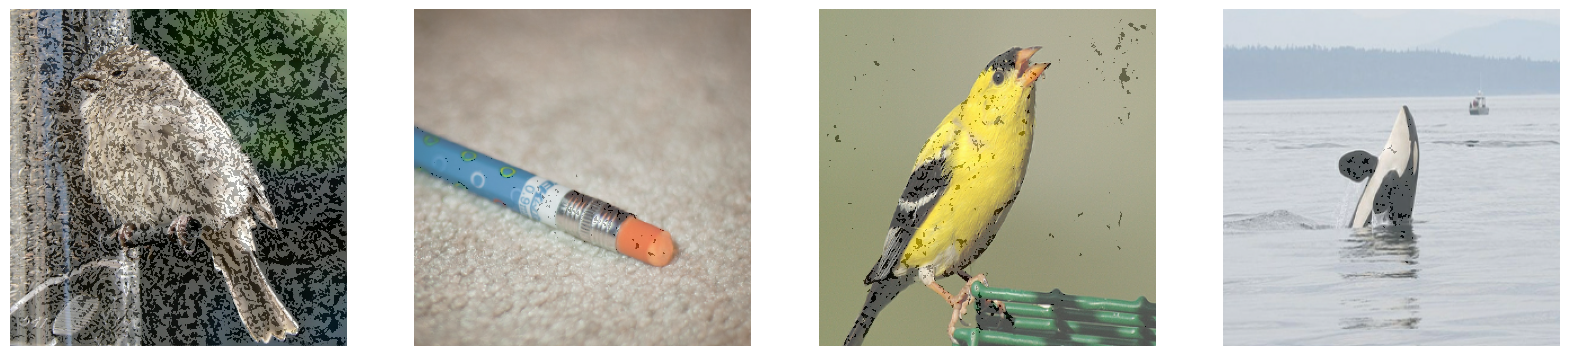

In [9]:
# Plot integrated gradients reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Umwandeln in Tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])

    # Berechne Integrated Gradients
    saliency_map = integrated_gradients(model, input_tensor, target_class)

    # Über Farbkanäle mitteln
    saliency_map = np.mean(saliency_map[0], axis=0)

    # Originalbild + Heatmap
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=0.3)
    axs[i].axis('off')

plt.show()

**4 | Change the baseline and comment on the results—do they change?**

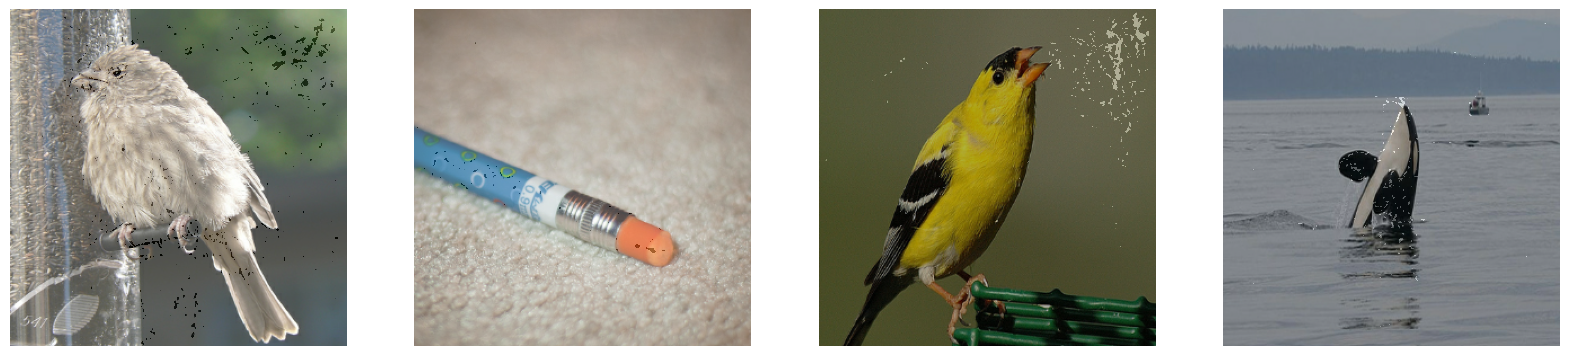

In [10]:
# Use a different baseline of all ones
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):

    # Convert the image to a tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    # New baseline of all ones
    baseline = torch.ones_like(input_tensor)
    target_class = int(labels[i])

    # Compute integrated gradients with the new baseline
    saliency_map = integrated_gradients(model, input_tensor, target_class, baseline=baseline)

    # Aggregate across color channels
    saliency_map = np.mean(saliency_map[0], axis=0)

    # Plot original image and overlay new heatmap
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=0.3)
    axs[i].axis('off')

plt.show()

**5 | Suggest an explanation for your observation if the results are different and suggest an alternative method.**

When we switched the baseline from all zeros to all ones, the attribution maps shifted noticeably. With the “all-ones” baseline, some regions that were previously highlighted now appear muted or noisy, and vice versa. This happens because Integrated Gradients accumulates gradients along the straight-line path from the baseline to the input—if the baseline lies far outside the data manifold (e.g. a bright white image), the intermediate images can be unrealistic, causing erratic gradients and spurious attributions.

**Alternative approach:**  
To get more stable, meaningful heatmaps, we can:

- **Use multiple baselines** (e.g. several random or blurred versions of the image) and average the attributions. This reduces sensitivity to any single, unrepresentative baseline.  
- **Switch to SmoothGrad**: add small noise to the input multiple times, compute gradients for each, and average them. This denoises the saliency map and sharpens focus on truly important pixels.  

Both methods tend to produce cleaner, more robust attributions when a single baseline choice proves unreliable.

**6 | Compare your results by implementing Captum's `IntegratedGradients` method.**

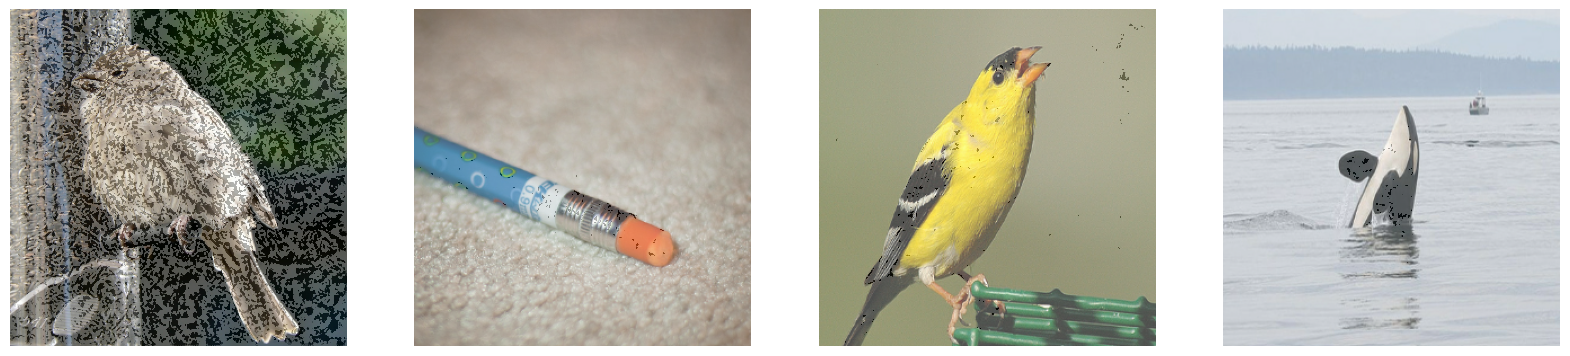

In [11]:
# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Plot Integrated Gradients reults from Captum library for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):

    # Convert the image to a tensor
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    # Zero baseline
    baseline = torch.zeros_like(input_tensor)
    target_class = int(labels[i])

    # Compute Captum's Integrated Gradients
    attributions = ig.attribute(
        inputs=input_tensor,
        baselines=baseline,
        target=target_class,
        n_steps=50
    )

    # Aggregate across color channels
    saliency_map = attributions.detach().cpu().numpy()
    saliency_map = np.mean(saliency_map[0], axis=0)

    # Plot original image and overlay Captum heatmap
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=0.3)
    axs[i].axis('off')

plt.show()

## Occlusion

**1 | Use Captum's built-in occlusion functionality to derive and plot saliency maps for all images.**

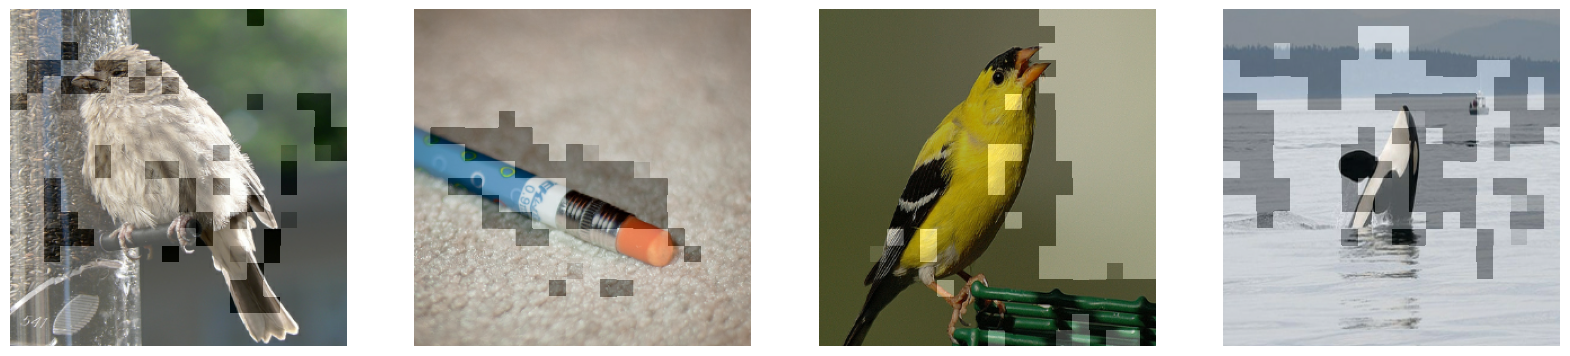

In [13]:
# Initialize Occlusion
occlusion = Occlusion(model)

# Plot occlusion reults for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    
    # Convert to tensor and set up inputs
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    baseline = torch.zeros_like(input_tensor)
    target_class = int(labels[i])

    # Compute Occlusion attributions (window über alle 3 Kanäle, 15×15 Patch)
    attributions = occlusion.attribute(
        inputs=input_tensor,
        baselines=baseline,
        strides=(3, 15, 15),
        sliding_window_shapes=(3, 15, 15),
        target=target_class
    )

    # Aggregate across channels
    saliency_map = attributions.detach().cpu().numpy()
    saliency_map = np.mean(saliency_map[0], axis=0)

    # Overlay on the original image
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=0.3)
    axs[i].axis('off')

plt.show()

**2 | Analyze how different window sizes affect your results and discuss how you would determine the optimal size.**

With Occlusion, the size of the sliding window acts like a “zoom” control on your saliency map:

- **Small windows** (e.g. 5×5 pixels)  
  - **High resolution**: you can pinpoint tiny, detailed regions that influence the model.  
  - **High noise**: each patch is so small that occluding it may not change the model’s output much, leading to weak or unstable attribution signals.  
  - **Slow**: many more patches to evaluate, so computation time skyrockets.

- **Large windows** (e.g. 50×50 pixels)  
  - **Coarse localization**: you lose fine detail, but you see broader regions (e.g. “this half of the image matters most”).  
  - **Smoother maps**: larger perturbations tend to produce clearer drops in confidence, so the map is less noisy.  
  - **Faster**: fewer patches to evaluate, so it runs more quickly.

### How to pick the “right” window size

1. **Deletion/insertion metrics**  
   - Gradually occlude (delete) the most important patches and measure how rapidly the model’s confidence falls (deletion).  
   - Or gradually insert patches back into a blank image and see how quickly confidence recovers (insertion).  
   - The window size that yields the steepest drop (or fastest recovery) typically captures important features most faithfully.

2. **Visual consistency and human judgment**  
   - Try several sizes and overlay the maps.  
   - Choose the smallest window that still produces a coherent, legible heatmap (not just speckles).  

3. **Computational budget**  
   - If you need faster turnaround, accept a slightly larger window for coarser but still meaningful maps.  
   - If detail is critical, invest in smaller windows and more compute.

By balancing resolution, noise, and runtime—and ideally validating with a quantitative deletion/insertion test—you can determine an occlusion window size that gives the most faithful saliency map for your use case.

## Grad-CAM

**1 | Use your theoretical knowledge of Grad-CAM to write a simple attribution method that returns a saliency map.**

In [14]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.model = model # The model for which to generate GradCAM
        self.target_layer = target_layer # The target layer in the model for which to generate GradCAM
        self.gradients = None # The gradients of the target layer
        self.activations = None # The activations of the target layer
        self._register_hooks() # Registers forward and backward hooks to capture activations and gradients of the target layer
        # To understand hooks, see: https://www.youtube.com/watch?v=syLFCVYua6Q
        # As well as the PyTorch documentation https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks
        
    def _register_hooks(self):
        # This function registers forward hooks to capture activations of the target layer
        # In this case, the small feature maps of the last convolutional layer that will be weighted by the gradients and upsampled to generate a CAM
        def forward_hook(module, input, output):
            self.activations = output # shape (batch, channels, height, width)

        def backward_hook(module, grad_in, grad_out):
            # This function registers backward hooks to capture gradients of the target layer necesary to weight the above activations
            self.gradients = grad_out[0] # we select the first element of the grad_out tuple because it contains the gradients, the second element contains the biases

        self.target_layer.register_forward_hook(forward_hook) # register forward hook
        self.target_layer.register_backward_hook(backward_hook) # register backward hook

    def generate_cam(self, input_tensor, target_class):
        self.model.zero_grad() # zero the gradients
       
        # Forward pass
        output = self.model(input_tensor)
        # Select score for the target class
        score = output[0, target_class]
        # Backward pass to populate self.gradients via our hook
        score.backward()
        # Pool the gradients across spatial dimensions
        pooled_gradients = torch.mean(self.gradients[0], dim=(1, 2))  # shape: (C,)
        # Get the activations from the forward hook
        activations = self.activations[0]  # shape: (C, H, W)
        # Weight the channels by the pooled gradients
        weighted_activations = activations * pooled_gradients.view(-1, 1, 1)
        # Sum over channels to get the raw CAM
        cam = torch.sum(weighted_activations, dim=0)  # shape: (H, W)
        # Apply ReLU
        cam = torch.relu(cam)
        # Normalize to [0,1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        # Upsample to input size
        cam = cam.unsqueeze(0).unsqueeze(0)  # shape: (1,1,H,W)
        cam = torch.nn.functional.interpolate(
            cam,
            size=(input_tensor.shape[2], input_tensor.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        cam = cam.squeeze().cpu().detach().numpy()

        return cam

**2 | Plot the saliency maps for all images.**

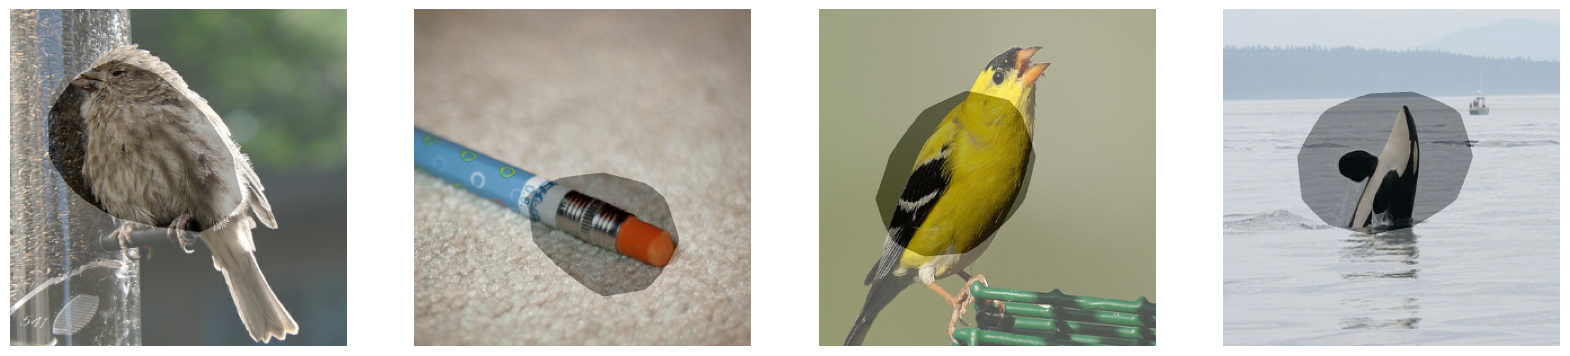

In [17]:
# YOUR CODE HERE
grad_cam = GradCAM(model, model.features[-1])  # Specify the target layer for Grad-CAM

fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert to tensor und Input vorbereiten
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])

    # Generiere Grad-CAM Heatmap
    cam = grad_cam.generate_cam(input_tensor, target_class)

    # Overlay auf dem Originalbild
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(cam, cmap=custom_cmap, alpha=0.3)
    axs[i].axis('off')

plt.show()

**3 | Use a few different target layers and report on how the saliency map changes with model depth.**

When we move our target layer from early to later convolutional layers, the shape and focus of the Grad-CAM heatmap change noticeably:

- **Shallow layers (e.g. early Inception block)**  
  - **Fine-grained edges and textures** are highlighted, but the map is noisy and scattered across many small features (e.g., individual feathers or carpet fibers).  
  - Because these layers have high spatial resolution but low semantic abstraction, the model “sees” a lot of low-level detail, not the whole object.

- **Mid-level layers (e.g. middle Inception blocks)**  
  - The heatmap begins to **cluster** around larger object parts (e.g., the bird’s body, the pencil tip).  
  - You still get some texture, but now those textures are grouped into semantically meaningful regions (e.g., “bird head,” “pencil tip”).

- **Deep layers (e.g. final convolutional layer before the classifier)**  
  - The map becomes **very coarse** and focuses on the “essence” of the object (e.g., the overall bird silhouette, the pencil as a whole).  
  - Spatial resolution is lower, but the attributions align best with the model’s high-level concept of the class.

**Takeaway:**  
By choosing a shallower layer you get more spatial detail (but more noise); by choosing a deeper layer you get cleaner, semantically stronger regions (but coarser heatmaps). In practice, the final convolutional layer usually offers the best trade-off between localization and semantic relevance for Grad-CAM.

**4 | Compare your results by implementing Captum's `LayerGradCam` method.**

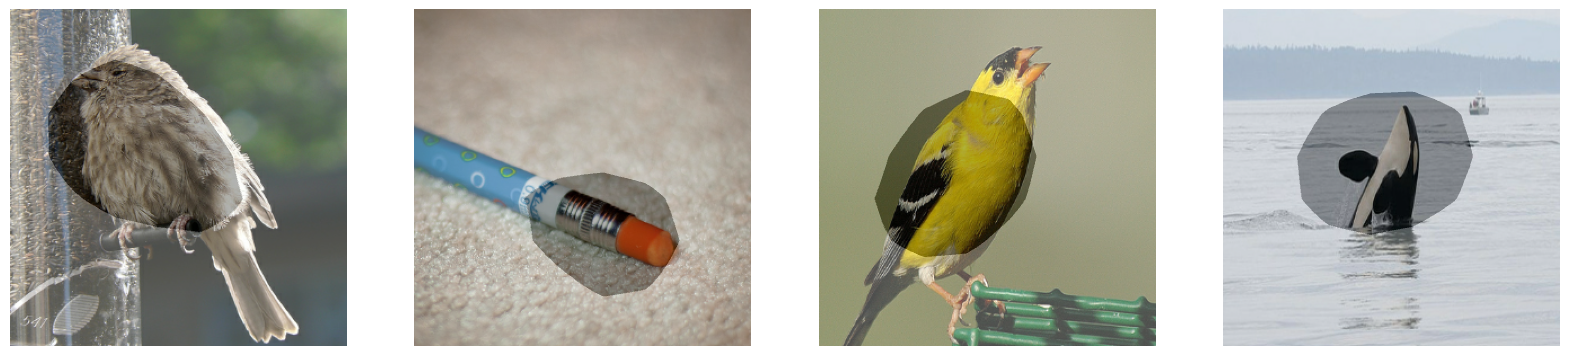

In [22]:
# Initialize Captum’s LayerGradCam for the same target layer used above
lgc = LayerGradCam(model, model.features[-1])

# Plot LayerGradCam results for all images
fig, axs = plt.subplots(1, images.shape[0], figsize=(5 * images.shape[0], 5))
for i, image in enumerate(images):
    # Convert to tensor and prepare input
    input_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    target_class = int(labels[i])

    # Compute LayerGradCam attributions
    attributions = lgc.attribute(
        inputs=input_tensor,
        target=target_class
    )
    # Upsample the multi‐channel map to the input size
    upsampled_attr = torch.nn.functional.interpolate(
        attributions,
        size=(input_tensor.shape[2], input_tensor.shape[3]),
        mode='bilinear',
        align_corners=False
    )
    # Aggregate across channels (sum) and normalize
    saliency_map = upsampled_attr.squeeze(0).sum(dim=0).detach().cpu().numpy()
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)

    # Overlay on the original image
    axs[i].imshow(utils.normalize(image))
    axs[i].imshow(saliency_map, cmap=custom_cmap, alpha=0.3)
    axs[i].axis('off')

plt.show()